In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Latent matrix from metadata

In [8]:
filename = 'data/2019_oct_sort_1000.csv'

In [9]:
!pwd

/home/cjergen/code/sailormoonvicky/eCommerce


In [14]:
import random
p = 1  # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         filename,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df.shape

(1000, 9)

In [15]:
df.shape

(1000, 9)

In [16]:
df.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [17]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-18 10:54:45 UTC,view,54900011,2146660887203676486,apparel.costume,NaN,64.35,515483062,00000042-3e3f-42f9-810d-f3d264139c50
1,2019-10-18 10:55:20 UTC,view,54900011,2146660887203676486,apparel.costume,NaN,64.35,515483062,00000042-3e3f-42f9-810d-f3d264139c50
2,2019-10-31 06:25:30 UTC,view,1005105,2053013555631882655,electronics.smartphone,apple,1349.46,513782162,00000056-a206-40dd-b174-a072550fa38c
3,2019-10-31 06:25:52 UTC,view,5100816,2053013553375346967,NaN,xiaomi,29.60,513782162,00000056-a206-40dd-b174-a072550fa38c
4,2019-10-31 06:23:12 UTC,view,1005115,2053013555631882655,electronics.smartphone,apple,955.84,513782162,00000056-a206-40dd-b174-a072550fa38c


In [18]:
def preprocessing_feat(X, drop_event_time=False):
    if drop_event_time:
        X = X.drop("event_time", axis=1)
    
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')
    return X_preprocessed

In [19]:
X_preprocessed = preprocessing_feat(df,  drop_event_time=True)

/tmp/ipykernel_958/4055017079.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')


In [20]:
X_preprocessed.shape

(445, 8)

## Pricing criterion

In [21]:
def make_column(row):
    if row["price"] < row["25%"]:
        return "low"
    elif row["price"] < row["75%"]:
        return "medium"
    else:
        return "high"

def pricing_criterion(X):
    pricing_guide = X.groupby('category_code')['price'].describe()[["25%", "75%"]].reset_index()
    X_merged = X.merge(pricing_guide, on="category_code", how="right")
    X_merged["price_category"] = X_merged.apply(lambda row: make_column(row), axis=1)
    return X_merged


In [22]:
X_merged = pricing_criterion(X_preprocessed)

In [23]:
def metadata(X):
    X['metadata'] = X[['category_code', 'brand', 'price_category']].apply(lambda x: ' '.join(x), axis = 1)
    return X


In [24]:
X_meta = metadata(X_merged)
X_meta.nunique()

event_type          3
product_id        310
category_id        61
category_code      50
brand              98
price             364
user_id           186
user_session      186
25%                50
75%                50
price_category      3
metadata          171
dtype: int64

In [25]:
X_meta.set_index(X_meta['product_id'], inplace=True)

In [26]:
print(X_meta.shape)
X_meta.head()

(445, 12)


,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,25%,75%,price_category,metadata
product_id,,,,,,,,,,,,
49800017,view,49800017,2126679654801604876,accessories bag,ritmix,12.32,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,low,accessories bag ritmix low
49800020,view,49800020,2126679654801604876,accessories bag,ritmix,15.43,537956308,00003599-a772-4c8a-9c22-0dfa4f6ecc83,13.8750,41.0500,medium,accessories bag ritmix medium
28401080,view,28401080,2053013566209917945,accessories bag,respect,66.67,516007189,000037a4-c043-4113-9b53-7bbb5d7c2bfe,13.8750,41.0500,high,accessories bag respect high
28719157,view,28719157,2116907519078040377,apparel shoes,salamander,127.42,532234792,00006cdc-ee07-41db-958a-232b53a1f4fd,72.5875,88.4875,high,apparel shoes salamander high
28717170,view,28717170,2053013565639492569,apparel shoes,respect,84.43,557816044,000097b7-14fd-4336-a0e6-c82c981f8817,72.5875,88.4875,medium,apparel shoes respect medium


### Count Vectorizer

In [27]:
count = CountVectorizer()
count_matrix = count.fit_transform(X_meta['metadata'])
count_df_1 = pd.DataFrame(count_matrix.toarray(), index=X_meta.product_id.tolist())
print(count_df_1.shape)
count_df_1.head()

(445, 170)


,0,1,2,3,4,5,6,7,8,9,...,160,161,162,163,164,165,166,167,168,169
49800017,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49800020,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28401080,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28719157,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28717170,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
count_df_1 = count_df_1.reset_index()

In [29]:
len(list(set(count_df_1.index)))#.nunique()

445

In [30]:
count_df_1.drop_duplicates(subset='index', keep='first', inplace=True) 
count_df_1["product_id"] = count_df_1["index"]
count_df_1.drop("index", axis=1, inplace=True)
count_df_1.head()

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,product_id
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800017
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49800020
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,28401080
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,28719157
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,28717170


### Dimensionality reduction

In [31]:
n = 50
svd = TruncatedSVD(n_components=n)
latent_df_1 = svd.fit_transform(count_df_1.set_index("product_id"))

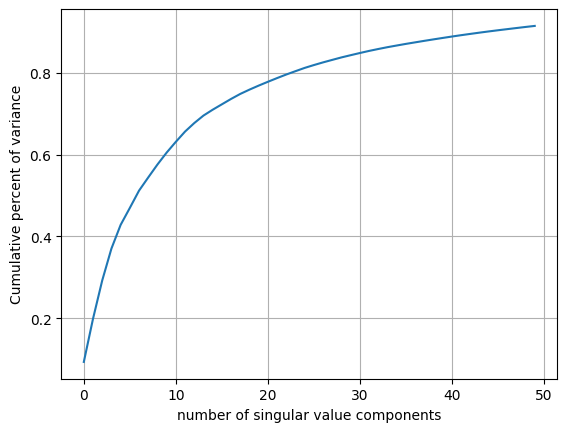

In [32]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [33]:
#count_df_1=count_df_1.set_index("product_id")
#count_df_1.head()
df_for_latent1 = count_df_1.product_id.tolist()

In [34]:
#n defined above
#n = 50
latent_df_1 = pd.DataFrame(latent_df_1[:,0:n], index=df_for_latent1)
print(latent_df_1.shape)
latent_df_1

(310, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
49800017,0.159126,0.094781,0.074467,0.867845,0.104342,0.451602,0.152625,-0.047068,0.053521,0.675642,...,-0.045987,0.001935,-0.003894,-0.019535,-0.025928,-0.057046,-0.008407,0.013529,-0.005326,-0.003170
49800020,0.409155,-0.382170,0.576855,-0.308769,0.238508,0.484030,0.073801,0.038980,0.071821,0.701121,...,-0.055212,0.036406,-0.005126,-0.012087,-0.023300,-0.058532,-0.007962,0.014408,0.005174,0.003138
28401080,0.265688,0.819887,-0.069625,-0.261478,0.272532,0.385874,0.291194,0.005876,0.199421,0.596432,...,0.027863,-0.036016,0.007413,-0.006381,-0.010101,-0.006414,0.000838,-0.003329,-0.017356,-0.012035
28719157,0.274873,0.828929,-0.039082,-0.235706,0.326835,0.626002,0.366783,0.021173,0.926960,-0.465166,...,-0.037565,0.040408,0.008441,-0.016203,-0.024203,-0.022875,-0.013149,0.004727,0.007653,-0.005456
28717170,0.424708,-0.360599,0.624793,-0.291207,0.327407,0.838738,0.194364,0.061150,1.015400,-0.473332,...,0.065657,-0.039286,-0.005252,0.018910,0.026040,0.025874,0.005982,-0.003767,0.008326,0.008330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8901444,0.405871,-0.403868,0.573468,-0.335038,0.207657,0.363650,0.009501,0.043420,0.016501,0.069495,...,0.012273,-0.003431,-0.006034,0.019502,0.020356,-0.000128,0.050239,0.048668,-0.077619,0.027378
10400294,0.156276,0.073684,0.071730,0.851527,0.074652,0.338353,0.090313,-0.043913,-0.001854,0.045490,...,0.034376,-0.060052,-0.006183,0.022782,0.034404,0.006628,0.105397,0.103441,-0.175691,0.052101
10400334,0.406306,-0.403267,0.574117,-0.325087,0.208818,0.370782,0.011488,0.042135,0.016445,0.070969,...,0.025151,-0.025581,-0.007416,0.030230,0.037033,0.005141,0.105841,0.104320,-0.165192,0.058409
10400398,0.259958,0.803929,-0.085135,-0.281876,0.228669,0.213571,0.211477,0.002942,0.025685,0.052357,...,-0.019487,0.014395,0.011609,-0.036070,-0.062426,-0.071357,-0.205063,-0.266210,0.464716,0.021333


In [35]:
latent_df_1.reset_index().drop_duplicates().shape

(310, 51)

In [36]:
#X_meta['product_id'].nunique()

# Latent matrix from event types

In [37]:
def preprocessing_event(X):
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    return X_preprocessed

In [38]:
df_event = preprocessing_event(df)
df_event.user_id.nunique()

186

In [39]:
dct = {'view': 1, 'cart': 3, 'purchase': 5}

In [40]:
df_event['rating'] = df_event['event_type'].map(dct)

In [41]:
df_event["rating"].sum()

743

In [42]:
# df_rating.shape

In [43]:
# df_rating = df_event.pivot_table(values='rating',
#                                  index='product_id',
#                                  columns='user_id',
#                                  aggfunc="sum").fillna(0)
# df_rating

In [44]:
df_event.nunique()

event_time       609
event_type         3
product_id       310
category_id       61
category_code     50
brand             98
price            364
user_id          186
user_session     186
rating             3
dtype: int64

In [45]:
df_event.drop_duplicates(subset='product_id',inplace=True)
df_event.nunique()

event_time       310
event_type         3
product_id       310
category_id       61
category_code     50
brand             98
price            290
user_id          147
user_session     147
rating             3
dtype: int64

In [46]:
%%time

df_rating = df_event.pivot(values='rating',
               index='product_id',
               columns='user_id').fillna(0)

df_rating

CPU times: user 7.24 ms, sys: 14.1 ms, total: 21.3 ms
Wall time: 15.1 ms


user_id,512483064,512600925,512652590,512843699,512845701,512893095,513035269,513160929,513192914,513196971,...,562786298,562883054,563195675,563543861,563842008,564098956,564555327,564879838,565847508,566031240
product_id,,,,,,,,,,,,,,,,,,,,,
1002532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35200189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43300127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45300048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
df_rating.sum().reset_index()[0].sum()

324.0

In [51]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    743
dtype: int64

In [48]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    324
dtype: int64

In [49]:
df_rating.reset_index()

user_id,product_id,512483064,512600925,512652590,512843699,512845701,512893095,513035269,513160929,513192914,...,562786298,562883054,563195675,563543861,563842008,564098956,564555327,564879838,565847508,566031240
0,1002532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1002540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1002542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1002544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1002633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,35200189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306,43300127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
307,45300048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,49800017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
svd = TruncatedSVD(n_components=75)
latent_df_2 = svd.fit_transform(df_rating)

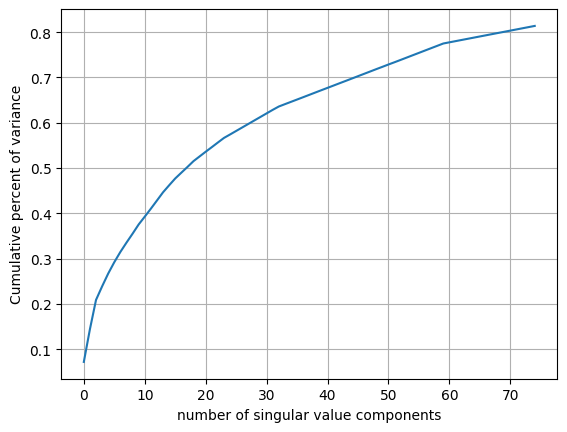

In [51]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [52]:
latent_df_2 = pd.DataFrame(latent_df_2, index=df_rating.reset_index().product_id.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
1002532,2.104480e-11,-3.382024e-11,4.523153e-12,3.879933e-09,2.466465e-08,2.754502e-08,-4.488288e-08,-2.891900e-08,-7.489823e-08,-6.242539e-08,...,5.204170e-17,-1.556914e-16,4.857226e-17,3.859760e-17,-1.595946e-16,-2.255141e-17,-3.469447e-17,1.790018e-16,1.283695e-16,2.081668e-16
1002540,2.104480e-11,-3.382024e-11,4.523153e-12,3.879933e-09,2.466465e-08,2.754502e-08,-4.488288e-08,-2.891900e-08,-7.489823e-08,-6.242539e-08,...,5.204170e-17,-1.556914e-16,4.857226e-17,3.859760e-17,-1.595946e-16,-2.255141e-17,-3.469447e-17,1.790018e-16,1.283695e-16,2.081668e-16
1002542,-9.763412e-11,-6.468698e-10,6.948508e-10,8.353499e-09,-3.776600e-08,-5.488495e-08,7.256762e-07,3.210369e-07,3.062096e-07,1.088219e-06,...,-1.932501e-01,-2.192493e-01,-7.878606e-02,-9.070462e-02,1.443464e-01,3.912473e-02,-9.966900e-02,-1.230051e-01,-3.825963e-02,5.690868e-03
1002544,-2.400190e-11,-2.258839e-12,-6.635807e-11,6.965073e-09,2.926892e-08,2.450396e-08,-2.290713e-08,-6.663451e-08,-3.293605e-08,-9.610173e-08,...,-1.006140e-16,5.551115e-17,-5.204170e-17,-2.081668e-16,-9.020562e-17,2.081668e-17,2.914335e-16,5.149960e-17,1.283695e-16,4.163336e-17
1002633,-2.400190e-11,-2.258839e-12,-6.635807e-11,6.965073e-09,2.926892e-08,2.450396e-08,-2.290713e-08,-6.663451e-08,-3.293605e-08,-9.610173e-08,...,-1.006140e-16,5.551115e-17,-5.204170e-17,-2.081668e-16,-9.020562e-17,2.081668e-17,2.914335e-16,5.149960e-17,1.283695e-16,4.163336e-17


In [53]:
latent_df_2.shape

(310, 75)

# Apply Cosine Similarity in Content and Collaborative Matrices


In [54]:
product_id=5100337

In [55]:
# Get the latent vectors for "Toy Story" from content and collaborative matrices
v1 = np.array(latent_df_1.loc[product_id]).reshape(1, -1)
v2 = np.array(latent_df_2.loc[product_id]).reshape(1, -1)

# Compute the cosine similarity of this movie with the others in the list
sim1 = cosine_similarity(latent_df_1, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

In [56]:
dictDf_1 = {'features': sim1} 
recommendation_df_1 = pd.DataFrame(dictDf_1, index = latent_df_1.index)
# recommendation_df_1.sort_values('features', ascending=False, inplace=True)

In [57]:
dictDf_2 = {'ratings': sim2} 
recommendation_df_2 = pd.DataFrame(dictDf_2, index = latent_df_2.index)
# recommendation_df_2.sort_values('ratings', ascending=False, inplace=True)

In [58]:
weight_features = 0.8

In [59]:
recommendation_combined = pd.merge(recommendation_df_1, recommendation_df_2, left_index=True, right_index=True)
recommendation_combined['hybrid'] = ((weight_features*recommendation_combined['features'] + (1-weight_features)*recommendation_combined['ratings']))

In [60]:
recommendation_combined.sort_values('ratings', ascending=False, inplace=True)
recommendation_combined

,features,ratings,hybrid
5100337,1.000000,1.000000,1.000000
1003306,0.756962,0.502473,0.706064
28719157,-0.000472,0.459707,0.091564
1004836,0.502462,0.411338,0.484237
6301402,-0.001282,0.392882,0.077551
...,...,...,...
1004785,0.505380,-0.412697,0.321765
1004777,0.249780,-0.426265,0.114571
1005132,0.505632,-0.507092,0.303087
3601244,-0.012701,-0.507562,-0.111673


In [61]:
recommendation_combined.head()

,features,ratings,hybrid
5100337,1.000000,1.000000,1.000000
1003306,0.756962,0.502473,0.706064
28719157,-0.000472,0.459707,0.091564
1004836,0.502462,0.411338,0.484237
6301402,-0.001282,0.392882,0.077551


In [73]:
def top_n_products(product_id, rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inouts for ranking: 'features', 'ratings', 'hybrid'"""
    
    feat_idx = rec_df.sort_values(ranking, ascending=False).index[0:n]
    counter = 0
    
    for i in feat_idx:
        meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
        
        if counter == 0:
            print(f"Top {n} recommendations for product_id {product_id}:")
            print(f"{i} - {meta_text} \n")
#             print("-----------------------")

        else:
            print(f"Rec {counter}) {i} - {meta_text}")
        
        counter += 1

In [74]:
top_n_products(1002532, recommendation_combined, X_meta, ranking='features')

Top 10 recommendations for product_id 1002532:
5100337 - electronics clocks apple medium 

Rec 1) 5100343 - electronics clocks apple medium
Rec 2) 5100566 - electronics clocks apple medium
Rec 3) 21400994 - electronics clocks casio medium
Rec 4) 1002540 - electronics smartphone apple medium
Rec 5) 1002544 - electronics smartphone apple medium
Rec 6) 1002633 - electronics smartphone apple medium
Rec 7) 1003306 - electronics smartphone apple medium
Rec 8) 1002532 - electronics smartphone apple medium
Rec 9) 1003141 - electronics smartphone apple medium


In [75]:
top_n_products(1002532, recommendation_combined, X_meta, ranking='ratings')

Top 10 recommendations for product_id 1002532:
5100337 - electronics clocks apple medium 

Rec 1) 1003306 - electronics smartphone apple medium
Rec 2) 28719157 - apparel shoes salamander high
Rec 3) 1004836 - electronics smartphone samsung medium
Rec 4) 6301402 - appliances kitchen kettle willmark low
Rec 5) 1005168 - electronics smartphone samsung medium
Rec 6) 18500029 - electronics tablet huion high
Rec 7) 1801689 - electronics video tv samsung low
Rec 8) 3100189 - appliances kitchen blender braun high
Rec 9) 27000002 - sport trainer housefit high


In [76]:
top_n_products(1002532, recommendation_combined, X_meta, ranking='hybrid')

Top 10 recommendations for product_id 1002532:
5100337 - electronics clocks apple medium 

Rec 1) 5100343 - electronics clocks apple medium
Rec 2) 5100566 - electronics clocks apple medium
Rec 3) 1003306 - electronics smartphone apple medium
Rec 4) 21400994 - electronics clocks casio medium
Rec 5) 5100570 - electronics clocks apple high
Rec 6) 1003141 - electronics smartphone apple medium
Rec 7) 1002633 - electronics smartphone apple medium
Rec 8) 1002544 - electronics smartphone apple medium
Rec 9) 1002540 - electronics smartphone apple medium
